In [ ]:
%run "datagetter.ipynb"
%run "basic_functions.ipynb"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB


/var/folders/7f/pn2lysgd6cx02fkc066bbrp40000gn/T/ipykernel_45937/1263838836.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_oil_df['ds'] = pd.to_datetime(wti_oil_df['ds'])


In [35]:
import timesfm
import pandas as pd
import matplotlib.pyplot as plt




def timesfm_forecast(train_df, test_df, alpha=0.05, figsize=(14, 6)):
    """
    Fit TimesFM model and generate forecasts
    
    Parameters:
    -----------
    train_df : DataFrame with 'ds' and 'y' columns
    test_df : DataFrame with 'ds' and 'y' columns
    alpha : float, confidence interval width (default: 0.05 for 95% CI)
    figsize : tuple, figure size for plots (default: (14, 6))
    """
    # Calculate appropriate context length based on data
    # Use 25% of training data length, then round to nearest power of 2
    target_len = int(len(train_df) * 0.25)
    # Find nearest power of 2, staying between 128 and 1024
    context_len = 2 ** int(np.log2(target_len))  # Round down to power of 2
    if context_len < 128:
        context_len = 128  # Minimum 2^7
    elif context_len > 1024:
        context_len = 1024  # Maximum 2^10
    print(f"Using context_len={context_len} based on training data length of {len(train_df)}")
    tfm = timesfm.TimesFm(
        hparams=timesfm.TimesFmHparams(
            per_core_batch_size=32,  # Batch size per GPU/TPU core. Higher batch sizes=more parallelism, but needs more memory.
            context_len=context_len, # Dynamically set based on dataset size
            horizon_len=len(test_df),# Forecasting horizon length
            input_patch_len=32,      # Length of input patches
            output_patch_len=128,    # Length of output patches
            num_layers=50,           # Number of transformer layers. More layers=more expressive model, but slower and heavier
            model_dims=1280,         # Dim. of transformer. A larger number means more powerful model, again at the cost of memory/speed.
            use_positional_embedding=False
        ),
        checkpoint=timesfm.TimesFmCheckpoint(huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
    )
    
    freq = pd.infer_freq(train_df['ds'])
    train_df['unique_id'] = '1'
    forecast = tfm.forecast_on_df(
        inputs=train_df,  # Input DataFrame containing the time-series data for training 
        freq=freq,        # Frequency of the time-series data (e.g., daily)
        value_name="y",   # Name of the column containing the values to be forecasted
        num_jobs=-1      # Number of parallel jobs to use for forecasting (-1 uses all available cores)
    )
    
    # Plot the results
    plt.figure(figsize=figsize)
    
    # Plot training data
    plt.plot(train_df['ds'], train_df['y'], label='Training Data', color='blue')
    
    # Plot test data
    plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='green')
    
    # Plot forecast
    plt.plot(forecast['ds'], forecast['timesfm'], label='Forecast', color='red')
    
    # Plot confidence intervals if available
    if 'lower' in forecast.columns and 'upper' in forecast.columns:
        plt.fill_between(forecast['ds'],
                        forecast['lower'], 
                        forecast['upper'], 
                        color='red', 
                        alpha=0.2,
                        label=f'{int((1-alpha)*100)}% CI')
    split_date = test_df['ds'].iloc[0]
    plt.axvline(split_date, color='tab:red', linestyle='--', label='Train/Test Split')
    plt.title('TimesFM Forecast')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return None, forecast  # Return model as None since TimesFM doesn't expose it



Using context_len=128 based on training data length of 205


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 64726.91it/s]


Processing dataframe with multiple processes.


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


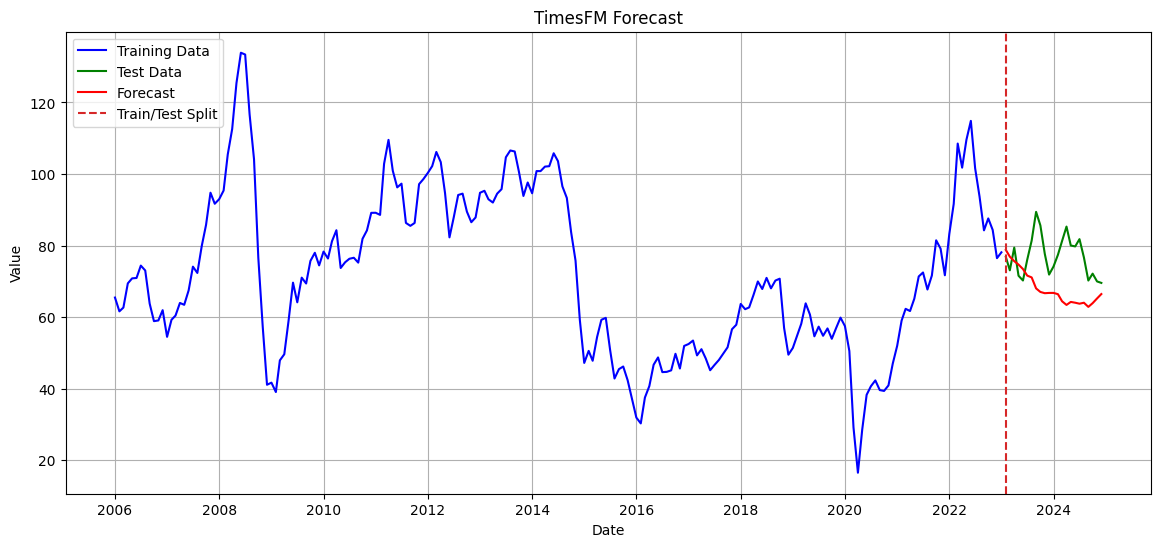

In [36]:
train_df, test_df = split_train_test(wti_oil_df, test_size=0.1)
times_fm_forecasts = timesfm_forecast(
    train_df=train_df,
    test_df=test_df,
)

Using context_len=1024 based on training data length of 21366


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 28111.96it/s]


Processing dataframe with multiple processes.


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


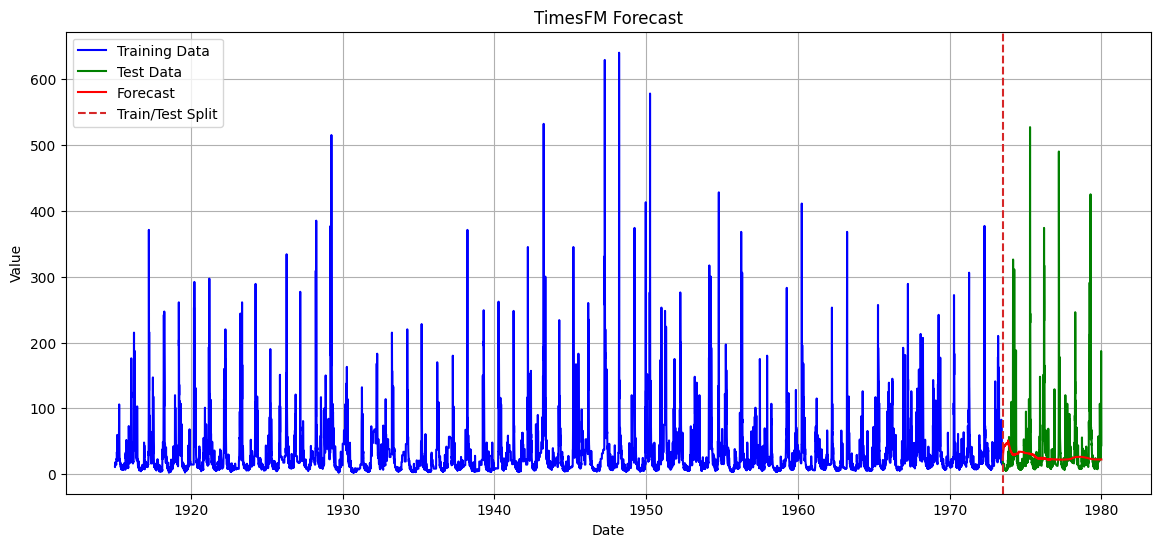

In [37]:
train_df, test_df = split_train_test(saugeen_river_df, test_size=0.1)
times_fm_forecasts = timesfm_forecast(
    train_df=train_df,
    test_df=test_df,
)


Using context_len=1024 based on training data length of 9532


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 74367.09it/s]


Processing dataframe with multiple processes.


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


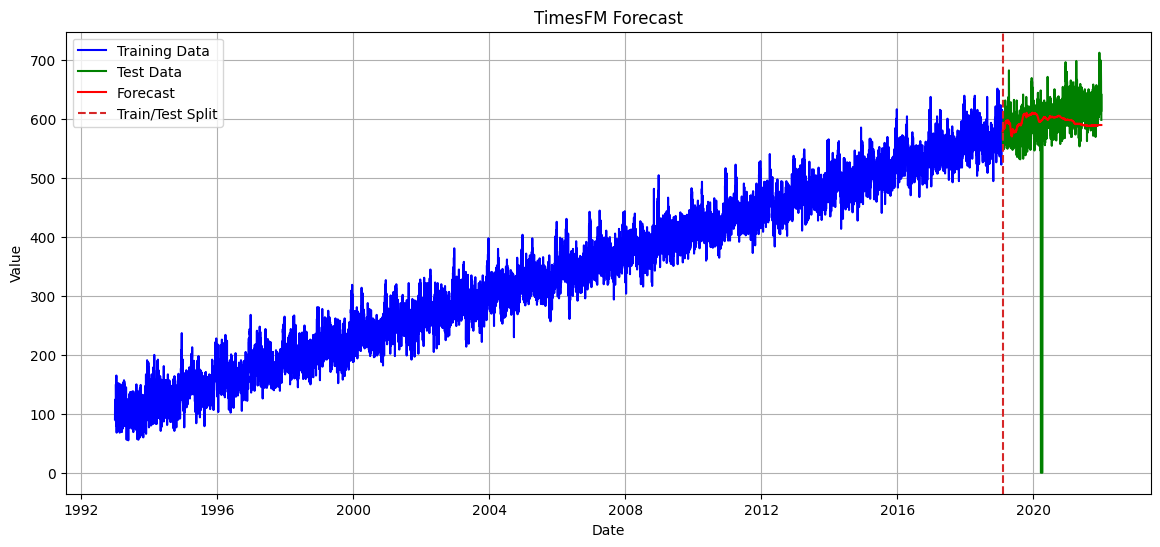

In [38]:
train_df, test_df = split_train_test(egg_sales_df, test_size=0.1)
times_fm_forecasts = timesfm_forecast(
    train_df=train_df,
    test_df=test_df,
)


Using context_len=1024 based on training data length of 4326


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 71575.15it/s]


Processing dataframe with multiple processes.


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)].
Finished preprocessing dataframe.
Finished forecasting.


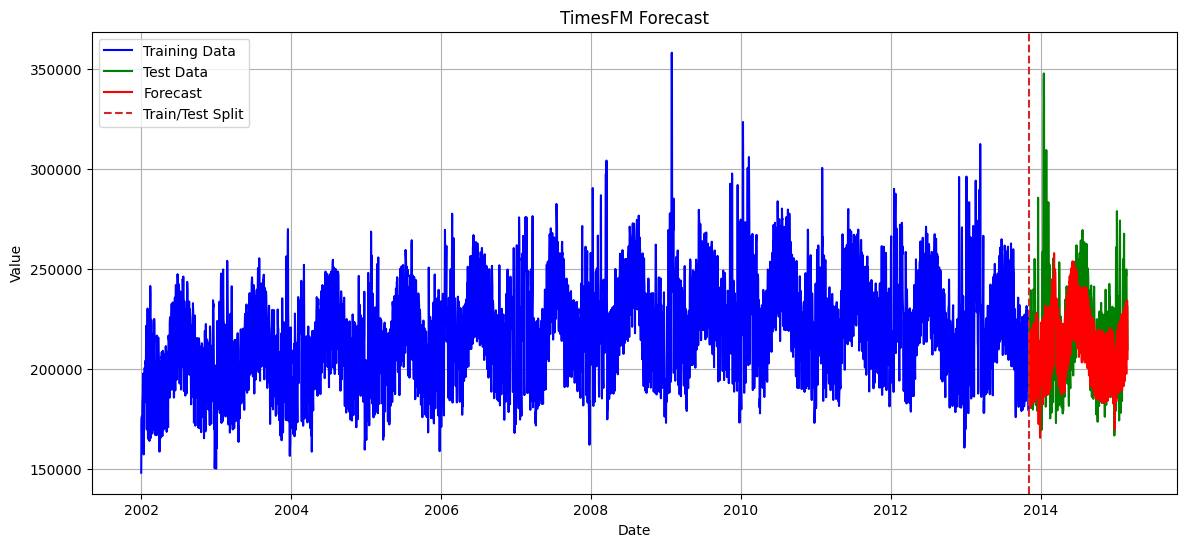

In [39]:
train_df, test_df = split_train_test(australian_electricity_demand_df, test_size=0.1)
times_fm_forecasts = timesfm_forecast(
    train_df=train_df,
    test_df=test_df,
)
